# 大盘涨跌预测

根据大盘当日过去10天的基本价格、技术面指标数据，预测未来1天的涨跌情况

## 数据处理 

1. 获取大盘基本价格和技术面指标数据
2. 数据预处理
3. 定义目标变量,确定观察期和表现期,构建基础数据集
4. 划分训练集和测试集

### 搭建模型
* LSTM
* activation 
* dropout
* softmax

### 编译模型
* optimizer
* learning_rate
* loss_function

### 训练模型
* batch_size
* epochs
* class_weight
* checkpoint
* earlystopping
* Save model

### 评价模型
* 准确率 evaluate.score
* 应用角度看，准确率是否是最优的评价指标？
* 简单的可视化分析

## 数据处理
### 1.获取大盘基本价格和技术面指标数据

In [423]:
from fxdayu_data import DataAPI
from datetime import datetime
import pandas as pd
import numpy
import talib
from talib import MA_Type

codes = '000001.XSHG'

price = DataAPI.candle(codes,'D',('open','high','low','close','volume'))
high = price['high']
low = price['low']
close = price['close']
volume = price['volume']

high = high.values.astype('double')
low = low.values.astype('double')
close = close.values.astype('double')
volume = volume.values.astype('double')


macd, macdsignal, macdhist = talib.MACD(close)
upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)

factors = {
    "MA5": talib.MA(close,5),
    "MA10" : talib.MA(close,10),
    "MA30" : talib.MA(close,30),
    "MA60" : talib.MA(close,60),
    "MA120" : talib.MA(close,120),
    "MA240" : talib.MA(close,240),
    "macd" : macd,
    "macdsignal" : macdsignal,
    "macdhist": macdhist,
    "bbands_up" : upper,
    "bbands_mid" : middle,
    "bbands_low" : lower,
    "mom" : talib.MOM(close, timeperiod=5),
    "rsi" : talib.RSI(close, timeperiod=14),
    "obv" : talib.OBV(close, volume),
    "trange" : talib.TRANGE(high, low, close),
    "minus_di" : talib.MINUS_DI(high, low, close, timeperiod=14),
    "minus_dm" : talib.MINUS_DM(high, low, timeperiod=14),
    "dx" : talib.DX(high, low, close, timeperiod=14),
    "cci" : talib.CCI(high, low, close, timeperiod=14),
    "cmo" : talib.CMO(close, timeperiod=14)
}

factors = pd.DataFrame(factors, price.index)
data = pd.concat([price,factors], axis=1)
data.index = data.index.date
print(data.shape)
data.head()

(1280, 26)


,close,high,low,open,volume,MA10,MA120,MA240,MA30,MA5,...,dx,macd,macdhist,macdsignal,minus_di,minus_dm,mom,obv,rsi,trange
2012-06-01,2373.44,2388.09,2365.44,2373.2199,7702192300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.702192e+09,NaN,NaN
2012-06-04,2308.55,2348.20,2308.23,2346.9800,9017934700,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.315742e+09,NaN,65.21
2012-06-05,2311.92,2323.30,2304.05,2313.7399,6607852800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.292110e+09,NaN,19.25
2012-06-06,2309.55,2323.11,2301.03,2315.5600,5853202800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.610924e+08,NaN,22.08
2012-06-07,2293.13,2328.67,2288.67,2324.6700,6023204800,NaN,NaN,NaN,NaN,2319.318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.584297e+09,NaN,40.00


### 2.数据预处理

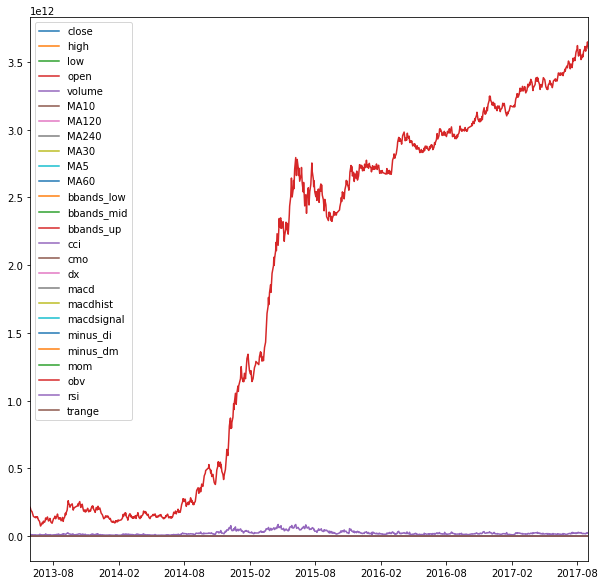

In [424]:
data = data.dropna()
data.head()
%matplotlib inline
data.plot(figsize=(10,10))

In [425]:
# data.columns
transform_column = ['obv']
# 1 
data[transform_column] = data[transform_column].apply(pd.Series.pct_change)
# data["obv_ex"] = data[transform_column].apply(pd.Series.pct_change) 
# 2
data = data.drop(["macdhist"],1) 
# 3
data["BOLL_range"] = data["bbands_up"] - data["bbands_mid"]
import numpy as np
data = data.replace([np.inf,-np.inf],np.nan)
data = data.dropna()
data.head()

# data.plot(kind = "kde",figsize=(10,10))

,close,high,low,open,volume,MA10,MA120,MA240,MA30,MA5,...,dx,macd,macdsignal,minus_di,minus_dm,mom,obv,rsi,trange,BOLL_range
2013-05-30,2317.75,2325.7199,2310.4899,2316.2500,11191303200,2301.07399,2250.072074,2191.103035,2245.729327,2308.940,...,24.477386,21.738487,14.616346,19.922809,74.611864,42.08,-0.052854,62.445791,15.23,30.018589
2013-05-31,2300.59,2325.5300,2299.3700,2320.7399,10816255400,2302.84599,2252.650574,2191.069869,2249.253993,2311.352,...,17.364259,20.850901,15.863257,21.502874,80.402345,12.06,-0.053934,57.410059,26.16,24.502413
2013-06-03,2299.25,2313.4300,2294.1100,2300.2100,9688281400,2302.77200,2255.364991,2191.017077,2252.768993,2312.586,...,14.044445,19.810987,16.652803,21.804529,79.919320,6.17,-0.051063,57.023350,19.32,21.079638
2013-06-04,2272.42,2297.1000,2264.7600,2297.1000,10189581800,2299.50300,2257.939408,2190.862369,2255.262993,2302.806,...,2.524030,16.630189,16.648280,27.628311,103.560797,-48.90,-0.056595,49.791461,34.49,35.935740
2013-06-05,2270.93,2276.8600,2260.8700,2270.7100,7648330300,2296.35600,2260.362824,2190.769869,2256.139327,2292.188,...,4.504273,13.829732,16.084571,27.483341,100.053598,-53.09,-0.045029,49.416641,15.99,35.961732


### 3.定义目标变量,确定观察期和表现期,构建基础数据集

In [426]:
# 用每10天的数据来预测未来5天的收益变化
xrange = 10
yrange = 1

# 取收盘价（close）作为衡量收益率变化的价格
price = data["close"]
#将特征数据X按15*30的矩阵重新组织，将Y定义为对应未来5天的收益率变化
dataX, dataY = [], []
dataNum = data.shape[0]

for i in range(dataNum - xrange - yrange + 1):
    dataX.append(data[i:i + xrange].values)
    dataY.append(price[i + xrange + yrange - 1] / price[i + xrange - 1] - 1)

import numpy as np
dataX = np.asarray(dataX)
dataY = np.asarray(dataY)
timeline = data.index[xrange + yrange - 1:]
print(dataX.shape)
print(dataY.shape)
print(timeline)

(1030, 10, 26)
(1030,)
Index([2013-06-18, 2013-06-19, 2013-06-20, 2013-06-21, 2013-06-24, 2013-06-25,
       2013-06-26, 2013-06-27, 2013-06-28, 2013-07-01,
       ...
       2017-08-18, 2017-08-21, 2017-08-22, 2017-08-23, 2017-08-24, 2017-08-25,
       2017-08-28, 2017-08-29, 2017-08-30, 2017-08-31],
      dtype='object', length=1030)


### 4.划分训练集和测试集

In [427]:
#分割数据集为测试集和训练集,获得每类数据集的样本数
num_examples = dataX.shape[0]
# 定义训练集占比
trainProp = 0.75
num_train_examples=int(num_examples*trainProp)

# 训练集
train_dataX = dataX[:num_train_examples]
train_dataY = dataY[:num_train_examples]
train_timeline = timeline[:num_train_examples]
# 测试集
test_dataX = dataX[num_train_examples:]
test_dataY = dataY[num_train_examples:]
test_timeline = timeline[num_train_examples:]

print(train_dataX.shape)
print(test_dataX.shape)

(772, 10, 26)
(258, 10, 26)


In [428]:
# 将训练集标签数据分类——根据涨跌幅阈值将类型分为:大涨、涨、跌、大跌 ( 对应3,2,1,0)，并做成one_hot vector形式
# one_hot vector: 3-[0,0,0,1] 2-[0,0,1,0] 1-[0,1,0,0] 0-[1,0,0,0]
from keras.utils.np_utils import to_categorical
def labels_transform(dataY, rise_threshold, fall_threshold):
    classified_dataY = np.zeros(dataY.shape[0])
    classified_dataY[dataY >= 0] = 2
    classified_dataY[dataY >= rise_threshold] = 3
    classified_dataY[dataY < 0] = 1
    classified_dataY[dataY <= fall_threshold] = 0
    classified_dataY = classified_dataY.reshape((-1,1))
    labels_one_hot = to_categorical(classified_dataY, 4)
    return labels_one_hot

In [429]:
# 设定大涨大跌的阈值
# 大涨定义为上涨样本里涨幅排名前25%的，大跌定义为下跌样本里跌幅排名前25%的。（此处只统计训练集数据，避免在测试集中引入未来函数）
rise_threshold = np.percentile(train_dataY[train_dataY>=0] , 75) #大涨阈值
fall_threshold = np.percentile(train_dataY[train_dataY<0] , 25) #大跌阈值
print(rise_threshold)
print(fall_threshold)

0.0168126517768
-0.0158144843551


In [430]:
# 转换dataY
tr_dataY = labels_transform(train_dataY, rise_threshold, fall_threshold)
te_dataY = labels_transform(test_dataY, rise_threshold, fall_threshold)
print(tr_dataY)

[[ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 ..., 
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]]


In [431]:
# 求训练集数据的均值和标准差
mean = data.loc[train_timeline].mean().values.reshape(1,1,data.shape[-1])
std = data.loc[train_timeline].std().values.reshape(1,1,data.shape[-1])
print(mean)
print(std)

[[[  2.82036829e+03   2.84643359e+03   2.78485499e+03   2.81519622e+03
     2.41067317e+10   2.81572146e+03   2.76763110e+03   2.69743417e+03
     2.80622120e+03   2.81816138e+03   2.79237970e+03   2.73917707e+03
     2.81827851e+03   2.89737996e+03   2.25395769e+01   6.84203258e+00
     2.89967257e+01   6.59856730e+00   6.54478438e+00   2.46739836e+01
     2.42060648e+02   5.29562189e+00   5.21657949e-03   5.34210163e+01
     6.46285890e+01   7.91014478e+01]]]
[[[  7.56444576e+02   7.72026468e+02   7.34047532e+02   7.55273497e+02
     1.69157641e+10   7.53226552e+02   6.97668320e+02   6.30772012e+02
     7.44027364e+02   7.55032868e+02   7.29504116e+02   7.07886579e+02
     7.57124213e+02   8.11231290e+02   1.08214032e+02   2.79992265e+01
     2.07834072e+01   8.23027064e+01   7.81355431e+01   9.82386287e+00
     2.58945767e+02   1.44346058e+02   4.91976507e-02   1.39996132e+01
     6.29262993e+01   7.97667390e+01]]]


In [432]:
# 输入层数据标准化
tr_dataX= (train_dataX - mean) / std
te_dataX = (test_dataX - mean) / std

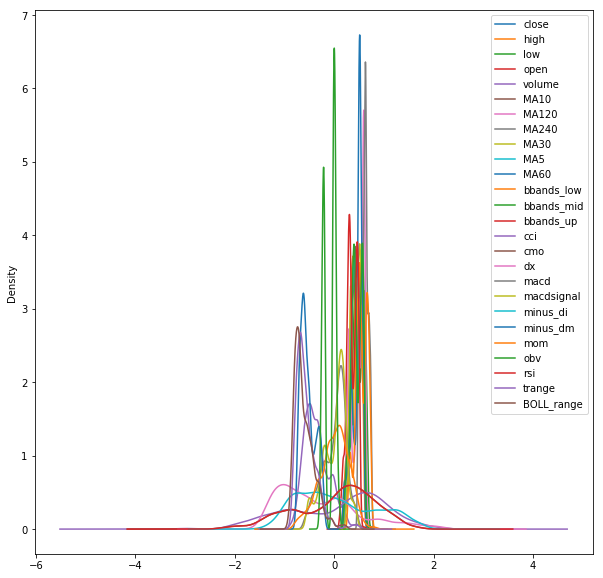

In [433]:
# 简单呈现下处理后的测试集dataX的分布
test = te_dataX.reshape(-1,te_dataX.shape[-1])
test = pd.DataFrame(test)
test.columns = data.columns
test.head()
test.plot(kind = "kde",figsize=(10,10))

## 搭建模型
* LSTM
* activation 
* dropout
* softmax
* batch_size

In [434]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

n_hidden = 10 # 定义每层神经网络节点个数
drop_prob = 0 # 定义dropout正则化比例 在数据量不大（信息不多）的情况下可以设为0
n_input = data.shape[-1] # 定义特征维度
num_layers = 2 # 定义模型中间层数数

### 训练模型
* batch_size
* epochs
* class_weight
* checkpoint
* earlystopping
* Save model

In [435]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

epochs = 5 # 定义全体训练集样本训练轮数
batch_size = 20 # 定义每次训练的样本个数
class_weight = {0:1,1:1,2:1,3:1} #每个类别的权重,用于强化某些类别的信号. (0:大跌,1:跌,2:涨,3:大涨)
filepath = "m1_best_w.hdf5"

In [436]:
def create_model():
    model = Sequential()
    model.add(LSTM(n_hidden,
                                  input_shape=(xrange, n_input),
                                  return_sequences=True))
    # 叠加模型层数
    for i in range(num_layers-1):
        model.add(LSTM(n_hidden,
                                      return_sequences=True))

    model.add(LSTM(n_hidden,
                                  return_sequences=False,
                                  dropout=drop_prob))
    model.add(Dense(4,activation="softmax"))
    return model

In [437]:
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                             optimizer="SGD", #Adam作为一种自适应优化器,可以根据模型训练状况自动调节权重优化精度
                             metrics=["accuracy"])
    return model

In [438]:
def train_model(model,dataX,dataY,validation_data=None):
    # 设置监听点
    checkpoint = ModelCheckpoint(filepath,
                                                          monitor='val_acc',
                                                          verbose=1,
                                                          save_best_only=True,
                                                          mode="max")
     # 设置提前终止训练
    earlystopping = EarlyStopping(monitor='val_acc',
                                                        patience=3,
                                                        verbose=1,
                                                        mode="max")
    # 训练模型
    model.fit(dataX,
                    dataY,
                    validation_data=validation_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    class_weight=class_weight,
                    callbacks=[checkpoint,earlystopping])
    return model

In [439]:
# from tools.model import *
model = create_model() # 创建模型
# optimizer = "SGD"
model = compile_model(model) #编译模型

model = train_model(model,
                    dataX = tr_dataX,
                    dataY = tr_dataY,
                    validation_data=(te_dataX,te_dataY))

Train on 772 samples, validate on 258 samples
Epoch 1/5
772/772 [==============================] - 26s - loss: 1.3721 - acc: 0.2474 - val_loss: 1.2757 - val_acc: 0.5465
Epoch 2/5
772/772 [==============================] - 3s - loss: 1.3296 - acc: 0.4054 - val_loss: 1.2153 - val_acc: 0.5543
Epoch 3/5
772/772 [==============================] - 3s - loss: 1.3014 - acc: 0.4132 - val_loss: 1.1711 - val_acc: 0.5620
Epoch 4/5
772/772 [==============================] - 3s - loss: 1.2831 - acc: 0.4132 - val_loss: 1.1385 - val_acc: 0.5620
Epoch 5/5
772/772 [==============================] - 3s - loss: 1.2702 - acc: 0.4132 - val_loss: 1.1139 - val_acc: 0.5620


In [440]:
## 加载weights最优的模型
m1 = create_model()
m1.load_weights("m1_best_w.hdf5")
m1 = compile_model(m1)
score = m1.evaluate(te_dataX, te_dataY)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

224/258 [=========================>....] - ETA: 1s Test loss: 1.17114875945
Test accuracy: 0.562015503876


In [441]:
# 输出对测试集的预测结果
pred_result = model.predict(te_dataX)
pre = np.argmax(pred_result, axis=1)
act = np.argmax(te_dataY, axis=1)
result = pd.concat([pd.Series(np.asarray(test_timeline)),pd.Series(pre),pd.Series(act)],axis=1)
result.columns = ["datetime","pre","act"]
result.set_index("datetime", inplace = True)
print("预测结果如下：")
result.head()

预测结果如下：


,pre,act
datetime,,
2016-08-11,2,1
2016-08-12,2,2
2016-08-15,2,3
2016-08-16,2,1
2016-08-17,2,1


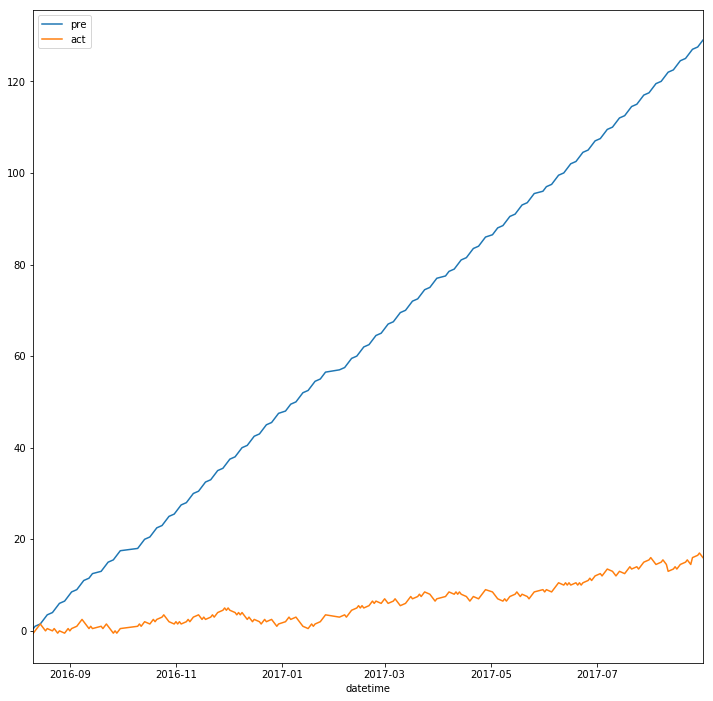

In [442]:
# 简单可视化——粗略较较下预测收益和真实收益的累积走势
pre_cum = (pre - 1.5).cumsum()
act_cum = (act - 1.5).cumsum()
cum_trend = pd.concat([pd.Series(np.asarray(test_timeline)),pd.Series(pre_cum),pd.Series(act_cum)],axis=1)
cum_trend.columns = ["datetime","pre","act"]
cum_trend.set_index("datetime", inplace = True)
%matplotlib inline
cum_trend.plot(figsize=(12,12))

In [443]:
print("预测大涨出现次数 = %s" %len(result[result["pre"] == 3]))
print("预测大跌出现次数 = %s" %len(result[result["pre"] == 0]))

预测大涨出现次数 = 0
预测大跌出现次数 = 0


In [444]:
true_rise = result[(result["pre"]==3) & (result["act"]==3)] #预测大涨实际大涨
true_fall = result[(result["pre"]==0) & (result["act"]==0)] #预测大跌实际大跌
false_rise = result[(result["pre"]==3) & (result["act"] != 3)] #预测大涨实际未大涨
false_fall = result[(result["pre"] == 0) & (result["act"] != 0)] #预测大跌实际未大跌
print("P(pre_rise|act_rise)=",len(true_rise)/(len(result[result["act"] == 3])+0.0000000001))
print("P(pre_fall|act_fall)=", len(true_fall) / (len(result[result["act"] == 0]) + 0.0000000001))
print("P(pre_rise|act_notrise)=",len(false_rise)/(len(result[result["act"] != 3])+0.0000000001))
print("P(pre_fall|act_notfall)=", len(false_fall) / (len(result[result["act"] != 0]) + 0.0000000001))

P(pre_rise|act_rise)= 0.0
P(pre_fall|act_fall)= 0.0
P(pre_rise|act_notrise)= 0.0
P(pre_fall|act_notfall)= 0.0


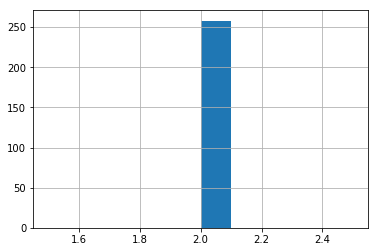

In [445]:
result.to_excel("szzs_prediction.xlsx")
pre_ex = result["pre"]
pre_ex.hist()

In [233]:
# tr_dataX.tofile("./data/tr_dataX.txt")
# tr_dataY.tofile("./data/tr_dataY.txt")
# te_dataX.tofile("./data/te_dataX.txt")
# te_dataY.tofile("./data/te_dataY.txt")

## 参数优化

In [35]:
# from sklearn.grid_search import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# from tools import model

# # 定义模型，暴露待优化参数的入口
# def create_model(optimizer='SGD',
#                                num_layers = 2,
#                                n_hidden = 10,
#                                drop_prob = 0):
#     m = model.create_model(xrange = 10,
#                            n_input=26,
#                            num_layers = num_layers,
#                            n_hidden = n_hidden,
#                            drop_prob = drop_prob) # 创建模型
#     m = model.compile_model(m, optimizer) #编译模型
#     return m

In [ ]:
# m = KerasClassifier(build_fn=create_model, verbose=0)
# batch_size = [10,15,20]
# epochs = [3,10,15]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# # KerasClassifier可以默认接受param_grid中传入的batch_size和epochs,无需在定义模型的涵数中暴露入口
# grid = GridSearchCV(estimator=m, param_grid=param_grid, n_jobs=1)
# grid_result = grid.fit(tr_dataX, tr_dataY)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for params, mean_score, scores in grid_result.grid_scores_:
#     print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

最优参数：
batch_size = 15
epochs = 10

In [62]:
# # create model
# m = KerasClassifier(build_fn=create_model, epochs=3, batch_size=20, verbose=0)
# # define the grid search parameters
# optimizer = ['SGD', 'Adam']
# param_grid = dict(optimizer=optimizer)
# grid = GridSearchCV(estimator=m, param_grid=param_grid, n_jobs=1)
# grid_result = grid.fit(tr_dataX, tr_dataY)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for params, mean_score, scores in grid_result.grid_scores_:
#     print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.363519 using {'optimizer': 'SGD'}
0.363497 (0.058248) with: {'optimizer': 'SGD'}
0.334982 (0.073072) with: {'optimizer': 'Adam'}

In [63]:
# # create model
# m = KerasClassifier(build_fn=create_model, epochs=3, batch_size=20, verbose=0)
# # define the grid search parameters
# num_layers = [1, 2, 3]
# n_hidden = [10,15,20]
# param_grid = dict(num_layers = num_layers, n_hidden = n_hidden)
# grid = GridSearchCV(estimator=m, param_grid=param_grid, n_jobs=1)
# grid_result = grid.fit(tr_dataX, tr_dataY)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for params, mean_score, scores in grid_result.grid_scores_:
#     print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.421734 using {'n_hidden': 10, 'num_layers': 2}
0.336154 (0.110950) with: {'n_hidden': 10, 'num_layers': 1}
0.421706 (0.020538) with: {'n_hidden': 10, 'num_layers': 2}
0.410048 (0.024941) with: {'n_hidden': 10, 'num_layers': 3}
0.308951 (0.131530) with: {'n_hidden': 15, 'num_layers': 1}
0.350557 (0.064827) with: {'n_hidden': 15, 'num_layers': 2}
0.412632 (0.025683) with: {'n_hidden': 15, 'num_layers': 3}
0.323299 (0.081235) with: {'n_hidden': 20, 'num_layers': 1}
0.349239 (0.062971) with: {'n_hidden': 20, 'num_layers': 2}
0.375039 (0.067391) with: {'n_hidden': 20, 'num_layers': 3}

### 性能优化
1. open、high、low、close、MA、VOL、obv 转换为变化率
2. 剔除MACD（冗余）
3. BOLL转换为通道口径（仅保留标准差 趋势项冗余）

In [92]:
data.columns

Index(['close', 'high', 'low', 'open', 'volume', 'MA10', 'MA120', 'MA240',
       'MA30', 'MA5', 'MA60', 'bbands_low', 'bbands_mid', 'bbands_up', 'cci',
       'cmo', 'dx', 'macd', 'macdhist', 'macdsignal', 'minus_di', 'minus_dm',
       'mom', 'obv', 'rsi', 'trange'],
      dtype='object')

In [93]:
# col_names = ["macd","macdsignal","minus_di","minus_dm","dx","mom","rsi","trange"]
# %matplotlib inline
# data[col_names].plot(figsize=(10,10))

In [94]:
# data.columns
transform_column = ['obv']
# 1 
data[transform_column] = data[transform_column].apply(pd.Series.pct_change) 
# 2
data = data.drop(["macdhist","obv"],1) 
# 3
data["BOLL_range"] = data["bbands_up"] - data["bbands_mid"]
import numpy as np
data = data.replace([np.inf,-np.inf],np.nan)
data = data.dropna()
data.head()

,close,high,low,open,volume,MA10,MA120,MA240,MA30,MA5,...,dx,macd,macdsignal,minus_di,minus_dm,mom,obv,rsi,trange,BOLL_range
2013-05-30,2317.75,2325.7199,2310.4899,2316.2500,11191303200,2301.07399,2250.072074,2191.103035,2245.729327,2308.940,...,24.477386,21.738487,14.616346,19.922809,74.611864,42.08,-0.052854,62.445791,15.23,30.018589
2013-05-31,2300.59,2325.5300,2299.3700,2320.7399,10816255400,2302.84599,2252.650574,2191.069869,2249.253993,2311.352,...,17.364259,20.850901,15.863257,21.502874,80.402345,12.06,-0.053934,57.410059,26.16,24.502413
2013-06-03,2299.25,2313.4300,2294.1100,2300.2100,9688281400,2302.77200,2255.364991,2191.017077,2252.768993,2312.586,...,14.044445,19.810987,16.652803,21.804529,79.919320,6.17,-0.051063,57.023350,19.32,21.079638
2013-06-04,2272.42,2297.1000,2264.7600,2297.1000,10189581800,2299.50300,2257.939408,2190.862369,2255.262993,2302.806,...,2.524030,16.630189,16.648280,27.628311,103.560797,-48.90,-0.056595,49.791461,34.49,35.935740
2013-06-05,2270.93,2276.8600,2260.8700,2270.7100,7648330300,2296.35600,2260.362824,2190.769869,2256.139327,2292.188,...,4.504273,13.829732,16.084571,27.483341,100.053598,-53.09,-0.045029,49.416641,15.99,35.961732


In [152]:
class_weight = {0:3,1:1,2:1,3:1} 
filepath = "m2_best_w.hdf5"
# 新建一个模型进行训练
m2 = create_model() # 创建模型
m2 = compile_model(m2) #编译模型
m2 = train_model(m2,
                               dataX = tr_dataX,
                               dataY = tr_dataY,
                               validation_data=(te_dataX,te_dataY))

Train on 773 samples, validate on 258 samples
Epoch 1/20
773/773 [==============================] - 6s - loss: 1.5989 - acc: 0.2962 - val_loss: 1.3447 - val_acc: 0.4341
Epoch 2/20
773/773 [==============================] - 2s - loss: 1.5191 - acc: 0.3635 - val_loss: 1.1391 - val_acc: 0.5271
Epoch 3/20
773/773 [==============================] - 2s - loss: 1.5058 - acc: 0.3687 - val_loss: 1.0923 - val_acc: 0.4806
Epoch 4/20
773/773 [==============================] - 3s - loss: 1.4924 - acc: 0.3790 - val_loss: 1.0306 - val_acc: 0.5426
Epoch 5/20
773/773 [==============================] - 3s - loss: 1.4902 - acc: 0.3842 - val_loss: 1.0730 - val_acc: 0.4767
Epoch 6/20
773/773 [==============================] - 2s - loss: 1.4841 - acc: 0.3855 - val_loss: 1.0199 - val_acc: 0.5465
Epoch 7/20
773/773 [==============================] - 3s - loss: 1.4735 - acc: 0.4088 - val_loss: 1.0260 - val_acc: 0.5388
Epoch 8/20
773/773 [==============================] - 3s - loss: 1.4731 - acc: 0.4062 - val_l

In [142]:
## 加载weights最优的模型
m2 = create_model()
m2.load_weights("m2_best_w.hdf5")
m2 = compile_model(m2)
score2 = m2.evaluate(te_dataX, te_dataY,)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

256/258 [============================>.] - ETA: 0sTest loss: 0.933452933334
Test accuracy: 0.562015503876


In [143]:
# 输出对测试集的预测结果
pred_result2 = m2.predict(te_dataX)
pre2 = np.argmax(pred_result2, axis=1)
act2 = np.argmax(te_dataY, axis=1)
result2 = pd.concat([pd.Series(np.asarray(test_timeline)),pd.Series(pre2),pd.Series(act2)],axis=1)
result2.columns = ["datetime","pre","act"]
result2.set_index("datetime", inplace = True)
print("预测结果如下：")
result2.head()

预测结果如下：


,pre,act
datetime,,
2016-08-11,2,1
2016-08-12,2,2
2016-08-15,2,3
2016-08-16,2,1
2016-08-17,2,1


In [144]:
true_rise2 = result2[(result2["pre"]==3) & (result2["act"]==3)] #预测大涨实际大涨
true_fall2 = result2[(result2["pre"]==0) & (result2["act"]==0)] #预测大跌实际大跌
false_rise2 = result2[(result2["pre"]==3) & (result2["act"] != 3)] #预测大涨实际未大涨
false_fall2 = result2[(result2["pre"] == 0) & (result2["act"] != 0)] #预测大跌实际未大跌
print("P(pre_rise|act_rise)=",len(true_rise2)/(len(result2[result2["act"] == 3])+0.0000000001))
print("P(pre_fall|act_fall)=", len(true_fall2) / (len(result2[result2["act"] == 0]) + 0.0000000001))
print("P(pre_rise|act_notrise)=",len(false_rise2)/(len(result2[result2["act"] != 3])+0.0000000001))
print("P(pre_fall|act_notfall)=", len(false_fall2) / (len(result2[result2["act"] != 0]) + 0.0000000001))

P(pre_rise|act_rise)= 0.0
P(pre_fall|act_fall)= 0.0
P(pre_rise|act_notrise)= 0.0
P(pre_fall|act_notfall)= 0.0


## stateful LSTM
* stateful LSTM的特点是，在处理过一个batch的训练数据后，其内部状态（记忆）会被作为下一个batch的训练数据的初始状态。stateful LSTM使得我们可以在合理的计算复杂度内处理较长序列
* 设置方式：
   * 建模时指定batch_size
   * stateful = True
   * shuffle = False
   * 手动控制epoch,每个训练回合结束后将模型状态重置（reset）

In [112]:
def create_stateful_model():
    model = Sequential()
    model.add(LSTM(n_hidden,
                                  input_shape=(xrange, n_input),
                                  batch_size=batch_size,
                                  return_sequences=True,
                                  stateful=True))
    # 叠加模型层数
    for i in range(num_layers-1):
        model.add(LSTM(n_hidden,
                                      return_sequences=True,
                                      stateful=True))

    model.add(LSTM(n_hidden,
                                  return_sequences=False,
                                  stateful = True,
                                  dropout=drop_prob))
    model.add(Dense(4,activation="softmax"))
    return model

In [113]:
def train_stateful_model(model,
                                           dataX,
                                           dataY,
                                           validation_data=None):
    # 设置监听点
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode="max")

    max_val_acc = 0  # 当前模型在验证集上的最大准确率
    no_impro_counts = 0  # 训练过程中模型效果连续未得到优化的次数 用于earlystopping

    for i in range(epochs):
        his = model.fit(dataX,
                        dataY,
                        validation_data=validation_data,
                        batch_size=batch_size,
                        epochs=1,
                        verbose=1,
                        class_weight=class_weight,
                        callbacks=[checkpoint],
                        shuffle=False)

        if float(his.history["val_acc"][0]) > max_val_acc:
            max_val_acc = his.history["val_acc"][0]
            no_impro_counts = 0
        elif no_impro_counts > 3:
            print("Can't improve the model")
            return model
        else:
            no_impro_counts += 1
        model.reset_states()
    return model

In [114]:
filepath = "sm_best_w.hdf5"

sm = create_stateful_model() # 创建模型
sm = compile_model(sm) #编译模型

# stateful LSTM 需要严格按照模型设定好的batch_size输入数据进行训练
train_l = int(tr_dataX.shape[0] / batch_size) * batch_size
val_l = int(te_dataX.shape[0] / batch_size) * batch_size # 这里为了方便，直接用测试集数据代表验证集
sm = train_stateful_model(sm,
                                             dataX = tr_dataX[0:train_l],
                                             dataY = tr_dataY[0:train_l],
                                             validation_data=(te_dataX[0:val_l],te_dataY[0:val_l]))

Train on 760 samples, validate on 240 samples
Epoch 1/1
760/760 [==============================] - 4s - loss: 1.6175 - acc: 0.3026 - val_loss: 1.4938 - val_acc: 0.0125
Train on 760 samples, validate on 240 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 1.5557 - acc: 0.3289 - val_loss: 1.2321 - val_acc: 0.4625
Train on 760 samples, validate on 240 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 1.5026 - acc: 0.3724 - val_loss: 1.0747 - val_acc: 0.4625
Train on 760 samples, validate on 240 samples
Epoch 1/1
760/760 [==============================] - 1s - loss: 1.4805 - acc: 0.3724 - val_loss: 1.0065 - val_acc: 0.5208
Train on 760 samples, validate on 240 samples
Epoch 1/1
760/760 [==============================] - 1s - loss: 1.4730 - acc: 0.3829 - val_loss: 0.9667 - val_acc: 0.4750
Train on 760 samples, validate on 240 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 1.4645 - acc: 0.4000 - val_loss: 1.0307 - val_acc:

In [115]:
## 加载weights最优的模型
sm = create_model()
sm.load_weights("sm_best_w.hdf5")
sm = compile_model(sm)
test_l = val_l
scoreS = sm.evaluate(te_dataX, te_dataY)
print('Test loss:', scoreS[0])
print('Test accuracy:', scoreS[1])

258/258 [==============================] - 0s     
Test loss: 1.08778956094
Test accuracy: 0.496124031008


In [116]:
# 输出对测试集的预测结果
pred_result2 = m2.predict(te_dataX)
pre2 = np.argmax(pred_result2, axis=1)
act2 = np.argmax(te_dataY, axis=1)
result2 = pd.concat([pd.Series(np.asarray(test_timeline)),pd.Series(pre2),pd.Series(act2)],axis=1)
result2.columns = ["datetime","pre","act"]
result2.set_index("datetime", inplace = True)
print("预测结果如下：")
result2.head()

预测结果如下：


,pre,act
datetime,,
2016-08-11,2,1
2016-08-12,2,2
2016-08-15,2,3
2016-08-16,2,1
2016-08-17,2,1


In [117]:
true_rise2 = result2[(result2["pre"]==3) & (result2["act"]==3)] #预测大涨实际大涨
true_fall2 = result2[(result2["pre"]==0) & (result2["act"]==0)] #预测大跌实际大跌
false_rise2 = result2[(result2["pre"]==3) & (result2["act"] != 3)] #预测大涨实际未大涨
false_fall2 = result2[(result2["pre"] == 0) & (result2["act"] != 0)] #预测大跌实际未大跌
print("P(pre_rise|act_rise)=",len(true_rise2)/(len(result2[result2["act"] == 3])+0.0000000001))
print("P(pre_fall|act_fall)=", len(true_fall2) / (len(result2[result2["act"] == 0]) + 0.0000000001))
print("P(pre_rise|act_notrise)=",len(false_rise2)/(len(result2[result2["act"] != 3])+0.0000000001))
print("P(pre_fall|act_notfall)=", len(false_fall2) / (len(result2[result2["act"] != 0]) + 0.0000000001))

P(pre_rise|act_rise)= 0.0
P(pre_fall|act_fall)= 0.0
P(pre_rise|act_notrise)= 0.0
P(pre_fall|act_notfall)= 0.0


In [ ]:
result2.to_excel("enhance_prediction.xlsx")